In [3]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.integrate import quad
from torch.distributions.multivariate_normal import MultivariateNormal
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [114]:
def Radon_Nikodym_derivative(dist_pi, dist_mu, a_n):
    RN = dist_pi.log_prob(a_n) - dist_mu.log_prob(a_n)
    return RN

In [ ]:
class SoftLQREnvironment:
    def __init__(self, H, M, C, D, R, sigma, T, N, tau, gamma):
        """
        SoftLQR: 带熵正则的 LQR 问题
        状态方程： dX = (H X + M a )dt + sigma dW
        成本： ∫ (x^T C x + a^T D a + tau ln p(a|x)) dt + x_T^T R x_T
        控制策略： a ~ N(mean, cov)
        其中 mean = -D_eff^{-1} M^T S(t)x,  cov = tau * D_eff,
        D_eff = D + (tau/(2*gamma^2)) I.
        """
        self.H = H
        self.M = M
        self.C = C
        self.D = D
        self.R = R
        self.sigma = sigma
        self.T = T
        self.N = N
        self.dt = T/N
        self.time_grid = torch.linspace(0, T, N+1)
        self.tau = tau
        self.gamma = gamma
        self.D_eff = self.D + (self.tau / (2 * (self.gamma ** 2))) * torch.eye(2)
        self.dist_mu = MultivariateNormal(torch.zeros(2), gamma**2*torch.eye(2))
        self.S_values = self.solve_riccati_ode()
    
    def riccati_ode(self, t, S_flat):
        """Riccati ODE 求解函数，转换为向量形式"""
        S = torch.tensor(S_flat, dtype=torch.float32).reshape(2,2) # 2x2 矩阵
        # D_eff_inv = torch.linalg.inv(self.D_eff)
        S_dot = S.T @ self.M @ torch.linalg.inv(self.D_eff) @ self.M.T @ S - self.H.T @ S - S @ self.H - self.C
        return S_dot.flatten()
    
    def solve_riccati_ode(self):
        """使用 solve_ivp 求解 Riccati ODE"""
        S_T = self.R.flatten()  # 终止条件 S(T) = R
        indices = torch.arange(self.time_grid.size(0) - 1, -1, -1)  # 生成倒序索引
        time_grid_re = torch.index_select(self.time_grid, 0, indices)
        sol = solve_ivp(self.riccati_ode, [self.T, 0], S_T, t_eval = time_grid_re, atol = 1e-10, rtol = 1e-10)  # 逆向求解
        S_matrices = sol.y.T[::-1].reshape(-1, 2, 2)  # 转换回矩阵格式
        return dict(zip(tuple(self.time_grid.tolist()), S_matrices))

    def get_nearest_S(self, t):
        """找到最近的 S(t)"""
        nearest_t = self.time_grid[torch.argmin(torch.abs(self.time_grid - t))]
        return self.S_values[nearest_t.tolist()]
    
    def value_function(self, t, x):
        """计算新的 v(t, x) = x^T S(t) x + ∫[t,T] tr(σσ^T S(r)) dr + (T-t)C_{D,tau, gamma}"""
        # 第一部分：x^T S(t) x
        S_t = self.get_nearest_S(t)
        S_t = torch.tensor(S_t, dtype = torch.float32)
        value = x.T @ S_t @ x
        
        # 第二部分：积分项 ∫[t,T] tr(σσ^T S(r)) dr
        def integrand(r):
            S_r = self.get_nearest_S(r)
            return torch.trace(self.sigma @ self.sigma.T @ S_r)
        
        integral, _ = quad(integrand, t, self.T)  # 使用数值积分计算积分项
        value += integral

        # 第三部分：(T-t)C_{D,tau, gamma}
        # C_{D,tau, gamma} = -tau ln(tau^{m/2}/gamma^{m} * det(∑)^{1/2}), ∑-1 = D+tau/(2*gamma^2)I
        inv_matrix = torch.linalg.inv(self.D_eff)
        det_matrix = torch.det(inv_matrix)
        C = - self.tau * torch.log((self.tau / self.gamma ** 2) * torch.sqrt(det_matrix))
        entropic = (self.T - t) * C
        value += entropic

        return value
    
    def optimal_control(self, t, x):
        """计算最优控制分布 pi(·|t, x) = N(-(D+tau/(2*gamma^2)I)^(-1) M^T S(t) x, tau(D+tau/(2*gamma^2)I))"""
        S_t = self.get_nearest_S(t)
        S_t = torch.tensor(S_t, dtype=torch.float32)
        # mean
        mean_control = -torch.linalg.inv(self.D_eff) @ self.M.T @ S_t @ x
        # covarian
        cov_control = self.tau * self.D_eff
        # distribution
        control_dist = MultivariateNormal(mean_control, cov_control)
        return control_dist
    
    def reset(self):
        x0 = torch.tensor([torch.empty(1).uniform_(-2, 2), torch.empty(1).uniform_(-2, 2)], dtype = torch.float32)
        return x0

In [6]:
class PolicyNN(nn.Module):
    def __init__(self, hidden_size = 512):
        super(PolicyNN, self).__init__()

        self.hidden_layer1 = nn.Linear(1, hidden_size) 
        self.hidden_layer2 = nn.Linear(hidden_size, hidden_size)
        self.dim = 2

        # Output for phi 
        self.phi = nn.Linear(hidden_size, 2 * 2)
        # Output for L matrix for Sigma 
        self.sigma_L = nn.Linear(hidden_size, 2 * (2 + 1) // 2)

        # precompute 
        self.tri_indices = torch.tril_indices(self.dim, self.dim)
    
    def forward(self, t, x):
        """
        Forward pass to get the action distribution.
        Returns a MultivariateNormal distribution.
        """
        # Forward pass 
        t = t.view(-1, 1)  # Ensure t is a column vector 
        hidden = torch.relu(self.hidden_layer1(t)) 
        hidden = torch.sigmoid(self.hidden_layer2(hidden))

        # Compute phi 
        phi_flat = self.phi(hidden) 
        phi = phi_flat.view(-1, self.dim, self.dim)

        # Compute Sigma 
        L_flat = self.sigma_L(hidden) 
        # Create a lower triangular matrix L where L_flat fills the lower triangle 
        L = torch.zeros(self.dim, self.dim) 
        L[self.tri_indices[0], self.tri_indices[1]] = L_flat 
        
        # Compute Sigma = LL^T to ensure positive semi-definiteness 
        Sigma = L @ L.T

        # mean
        mean = phi @ x
        # variance
        cov_matirx = Sigma

        return MultivariateNormal(mean, cov_matirx)



In [137]:
def OfflinePolicyGradient(env, PolicyNN, n_episodes, lr):
    """
    dostring
    """
    optimizer = optim.Adam(PolicyNN.parameters(), lr = lr)

    cost_history = []
    for ep in range(n_episodes):
        # Sample x0
        x0 = env.reset()

        dW = torch.randn(env.N, 2) * np.sqrt(env.dt)
        # 1) 采样一条轨迹
        """
        一次Episode: t=0..T, 共N步(与env.N一致)
        记录 { t_n, x_n, a_n, cost_n, logp_n } + x_N 用于 terminal cost
        其中 cost_n = x_n^T C x_n + a_n^T D a_n (不含 tau*logp,后面再加)
        """
        t_list = []
        x_list = []
        a_list = []
        v_list = []
        cost_list = []
        logp_list = []
        x_tn = x0.clone()
        for n in range(env.N):
            # forward
            tn = n * env.dt
            # value
            v_n = env.value_function(tn, x_tn)

            tn = torch.tensor([tn], dtype=torch.float32)

            dist = PolicyNN.forward(tn, x_tn)
            a_n = dist.sample().squeeze()

            log_prob = Radon_Nikodym_derivative(dist, env.dist_mu, a_n)

            # cost
            cost_n = x_tn.T @ env.C @ x_tn + a_n.T @ env.D @ a_n

            # 储存
            t_list.append(tn)
            x_list.append(x_tn)
            a_list.append(a_n)
            v_list.append(v_n)
            cost_list.append(cost_n)
            logp_list.append(log_prob)

            # 显示Euler
            # drift = Hx + Ma
            drift = env.H @ x_tn + env.M @ a_n
            # noise = sigma dW
            noise = env.sigma @ dW[n]
            # Euler–Maruyama 更新状态
            x_next = x_tn + drift * env.dt + noise

            x_tn = x_next
        x_T = x_tn
        v_T = env.value_function(env.T, x_T)
        v_list.append(v_T)

        # 2) Actor更新
        v = torch.stack(v_list)
        delta_v = torch.diff(v)
        cost = torch.stack(cost_list)
        logp = torch.stack(logp_list)
        cost_history.append(sum(cost))

        inside = (delta_v + (cost + env.tau * logp) * env.dt).unsqueeze(1)
        G_hat = (logp @ inside).sum()
        optimizer.zero_grad()
        G_hat.backward()
        optimizer.step()

        if ep % 100 == 0:
            print(f"Epoch {ep}: Cost = {sum(cost).item():.6f}")

    return cost_history


In [ ]:
# test
policy = PolicyNN(hidden_size = 512)
t0 = 0
t0 = torch.tensor([t0], dtype=torch.float32)
x0 = torch.tensor([1.0, 1.0])
dist = policy.forward(t0, x0)
print(dist.mean.tolist(), dist.covariance_matrix.tolist())

[[0.02666565775871277, -0.79012131690979]] [[[0.07638513296842575, 0.12926465272903442], [0.12926465272903442, 0.257859468460083]]]


In [143]:
# test
H = torch.tensor([[1.0, 0.8], [0.1, 0.3]])
M = torch.tensor([[0.3, 0.1], [0.8, 1.0]])
sigma = torch.eye(2) * 0.5
C = torch.eye(2) * 10
D = torch.eye(2) * 0.005
R = torch.eye(2) * 100
T = 1
N = 20

tau = 0.1
gamma = 10
n_episodes = 3000
lr = 1e-4

# Initialize SoftLQR environment
env = SoftLQREnvironment(H, M, C, D, R, sigma, T, N, tau, gamma)

In [144]:
actor = PolicyNN(hidden_size = 256)

In [145]:
cost_history = OfflinePolicyGradient(env, actor, n_episodes, lr)

/var/folders/v2/6ng3y8s56xj9gxj_r0zfs4jm0000gn/T/ipykernel_16311/1401222682.py:60: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integral, _ = quad(integrand, t, self.T)  # 使用数值积分计算积分项


Epoch 0: Cost = 106.654572
Epoch 100: Cost = 514.501038
Epoch 200: Cost = 3748.445557
Epoch 300: Cost = 706.776794
Epoch 400: Cost = 854.817322
Epoch 500: Cost = 1298.966675
Epoch 600: Cost = 83.307343
Epoch 700: Cost = 38.260662
Epoch 800: Cost = 1447.443115
Epoch 900: Cost = 1917.269531
Epoch 1000: Cost = 447.675293
Epoch 1100: Cost = 111.433945
Epoch 1200: Cost = 968.679504
Epoch 1300: Cost = 149.975342
Epoch 1400: Cost = 42.524509
Epoch 1500: Cost = 1234.082397
Epoch 1600: Cost = 1844.163086
Epoch 1700: Cost = 246.337234
Epoch 1800: Cost = 481.447510
Epoch 1900: Cost = 247.105652
Epoch 2000: Cost = 1171.075562
Epoch 2100: Cost = 730.075256
Epoch 2200: Cost = 226.326248
Epoch 2300: Cost = 139.071411
Epoch 2400: Cost = 66.983727
Epoch 2500: Cost = 287.772003
Epoch 2600: Cost = 591.484863
Epoch 2700: Cost = 906.680176
Epoch 2800: Cost = 8.826900
Epoch 2900: Cost = 920.417542


In [139]:
print(cost_history)

[tensor(1053.5172), tensor(1347.3809), tensor(1392.6024), tensor(1718.4613), tensor(1888.3981), tensor(584.0425), tensor(1182.6707), tensor(1121.8651), tensor(538.9733), tensor(407.6958), tensor(1698.5032), tensor(2453.3184), tensor(1189.7892), tensor(1050.8735), tensor(859.1863), tensor(1912.1208), tensor(3852.9399), tensor(1969.4773), tensor(1833.2421), tensor(300.5902), tensor(432.1959), tensor(1377.7009), tensor(807.3536), tensor(1106.0637), tensor(1216.2783), tensor(172.2656), tensor(365.7819), tensor(1779.7356), tensor(840.9309), tensor(1277.1774), tensor(4633.2363), tensor(1383.1488), tensor(636.0114), tensor(537.7454), tensor(2393.7834), tensor(561.4659), tensor(402.1436), tensor(1406.8774), tensor(401.4258), tensor(1253.8568), tensor(1248.3185), tensor(452.9054), tensor(1790.9518), tensor(1520.2566), tensor(1194.5602), tensor(2716.7344), tensor(191.8905), tensor(1729.1057), tensor(712.1829), tensor(750.0048), tensor(1342.8481), tensor(4416.0010), tensor(316.1082), tensor(710.3

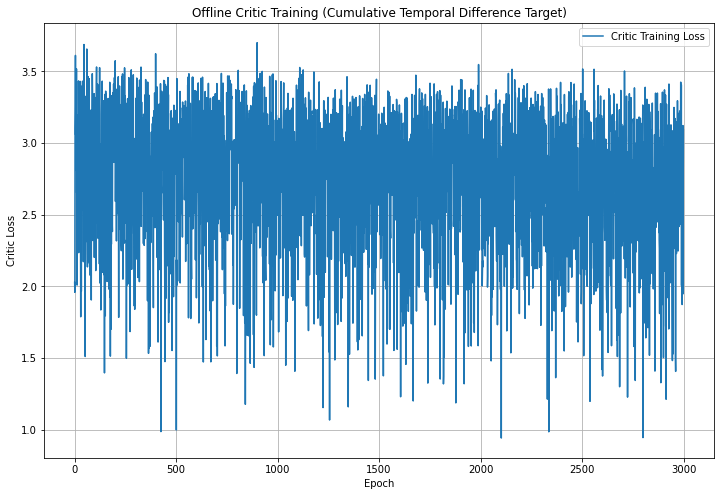

In [146]:
plt.figure(figsize = (12,8))
plt.plot(np.log10(cost_history), label='Critic Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Critic Loss')
plt.title('Offline Critic Training (Cumulative Temporal Difference Target)')
plt.grid(True)
plt.legend()
plt.show()

In [147]:
data = np.array(cost_history)  # 原始数据转换为 NumPy 数组
chunk_size = 50

# 保证长度是 chunk_size 的整数倍（可以裁剪或补0）
num_chunks = len(data) // chunk_size
print(num_chunks)
data_trimmed = data[:num_chunks * chunk_size]

# reshape 为 (num_chunks, chunk_size)，按行求均值
averages = data_trimmed.reshape(-1, chunk_size).mean(axis=1)
print(averages)

60
[1192.1265  1124.3422  1012.1465  1056.0485  1218.9878   878.22144
 1110.9835   845.06946 1060.1812   917.9325   932.1565   948.78204
  878.8287   996.4607   939.1944   988.3926  1086.2314   951.836
 1022.8468   890.5832   825.62573  948.5059  1068.5653   809.0279
  747.74927  695.673    721.3808   769.1641   816.54474  850.17993
  812.488    920.1337   718.1223   813.94354  791.40094  891.1308
  770.739    916.31915  849.8273  1003.014    766.88135  779.005
  762.23663  856.24194  906.599    829.0689   771.2427   813.6997
  735.1756   710.5243   711.0644   755.859    716.92206  783.6252
  756.2721   643.5697   679.73975  705.56647  618.2499   807.49097]


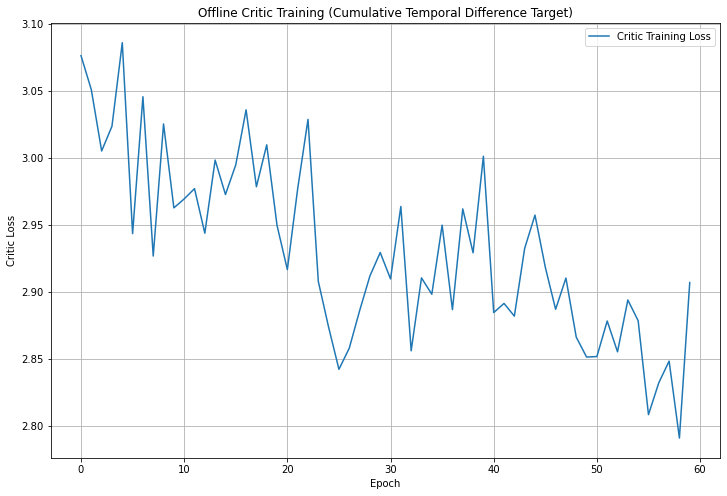

In [148]:
plt.figure(figsize = (12,8))
plt.plot(np.log10(averages), label='Critic Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Critic Loss')
plt.title('Offline Critic Training (Cumulative Temporal Difference Target)')
plt.grid(True)
plt.legend()
plt.show()